In [1]:
!pip install pyrtlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.1/228.1 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.7 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import datetime
import numpy as np
plt.rcParams.update({'font.size': 15})
from pyrtlib.climatology import AtmosphericProfiles as atmp
from pyrtlib.tb_spectrum import TbCloudRTE
from pyrtlib.utils import ppmv2gkg, mr2rh
from pyrtlib.apiwebservices import WyomingUpperAir
from pyrtlib.utils import import_lineshape
from pyrtlib.absorption_model import H2OAbsModel

/usr/local/lib/python3.10/dist-packages/pyrtlib/apiwebservices/erafive.py:19: UserWarning: Module CDSAPI must be installed to download ERA5 Reanalysis dataset.
  warnings.warn(


In [7]:
date = datetime.datetime(2023, 6, 12, 12)
station = 'DIAP' #Abidgan
df = WyomingUpperAir.request_data(date, station)
df.attrs['units']


{'pressure': 'hPa',
 'height': 'meter',
 'temperature': 'degC',
 'dewpoint': 'degC',
 'rh': '%',
 'mixr': 'g/kg',
 'station': None,
 'station_number': None,
 'time': None,
 'latitude': 'degrees',
 'longitude': 'degrees',
 'elevation': 'meter'}

/usr/local/lib/python3.10/dist-packages/pyrtlib/tb_spectrum.py:82: UserWarning: Number of levels too low (65) or minimum pressure value lower than 10 hPa (50.0). Please considering profile extrapolation. Levels number must be higher than 25 and pressure value lower than 10 hPa
  warnings.warn(f"Number of levels too low ({len(self.p)}) or "
/usr/local/lib/python3.10/dist-packages/pyrtlib/tb_spectrum.py:82: UserWarning: Number of levels too low (23) or minimum pressure value lower than 10 hPa (50.0). Please considering profile extrapolation. Levels number must be higher than 25 and pressure value lower than 10 hPa
  warnings.warn(f"Number of levels too low ({len(self.p)}) or "


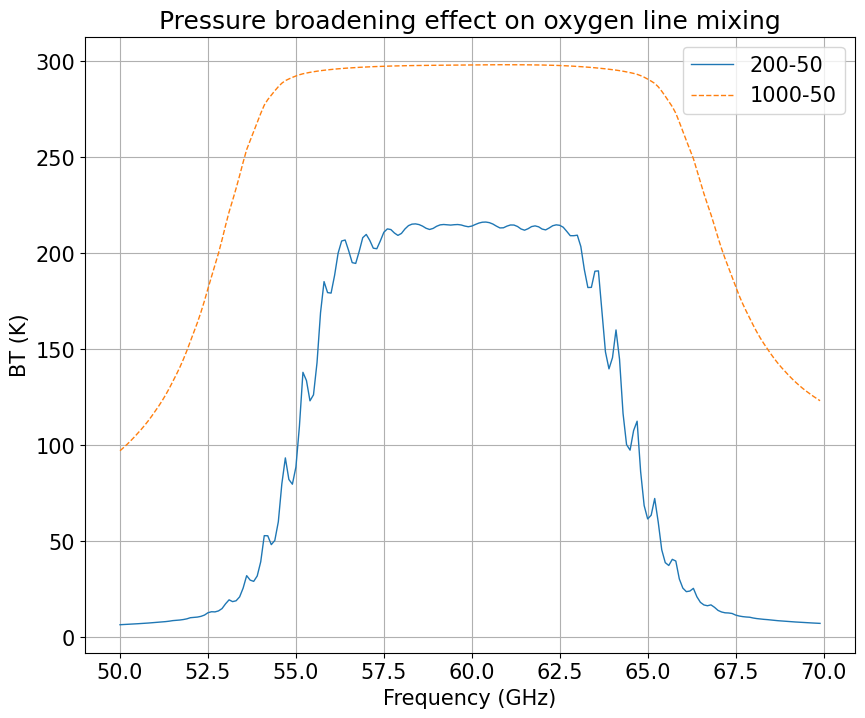

In [16]:
#WyomingUpperAir.get_stations(region = 'africa')
date = datetime.datetime(2023, 6, 12, 12)
station = 'DIAP' #Abidgan
df = WyomingUpperAir.request_data(date, station)
df.attrs['units']

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
mdl = 'R17'
ang = np.array([90.])
frq = np.arange(50, 70, 0.1)
nf = len(frq)
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('BT (K)')

pressure = df.pressure.values[42:65]
rh = df.rh.values[42:65]/100
height = df.height.values[42:65]/1000
temp = df.temperature.values[42:65]+273

'''
pressure = df.pressure.values
rh = df.rh.values/100
height = df.height.values/1000
temp = df.temperature.values+273
'''

rte1 = TbCloudRTE(df.height.values/1000, df.pressure.values, df.temperature.values+273, df.rh.values/100, frq, ang)
rte1.satellite = False
rte1.init_absmdl(mdl)

rte = TbCloudRTE(height, pressure, temp, rh, frq, ang)
rte.satellite = False
rte.init_absmdl(mdl)


df1 = rte1.execute()
df = rte.execute()

df = df.set_index(frq)
df1 = df1.set_index(frq)

df.tbtotal.plot(ax=ax, linewidth=1,label=('200-50'))
df1.tbtotal.plot(ax=ax,linewidth=1,label=('1000-50'),linestyle='--')

ax.grid(True, 'both')
ax.legend()
ax.set_title('Pressure broadening effect on oxygen line mixing')
ax.set_box_aspect(0.8)
plt.show()

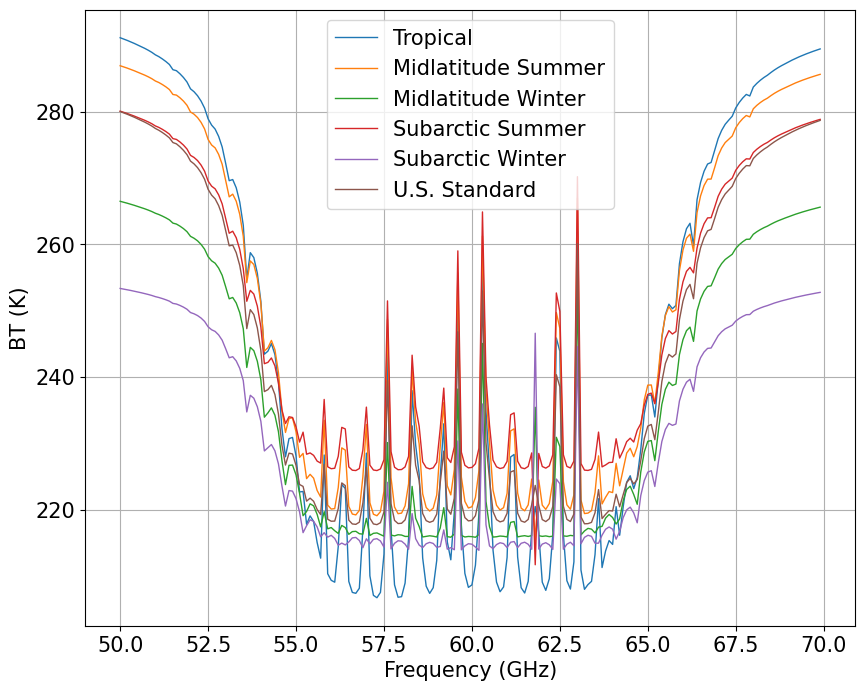

In [11]:
atm = ['Tropical',
       'Midlatitude Summer',
       'Midlatitude Winter',
       'Subarctic Summer',
       'Subarctic Winter',
       'U.S. Standard']


fig, ax = plt.subplots(1, 1, figsize=(12, 8))

for i in range(0, 6):
    z, p, d, t, md = atmp.gl_atm(i)
    gkg = ppmv2gkg(md[:, atmp.H2O], atmp.H2O)
    rh = mr2rh(p, t, gkg)[0] / 100

    mdl = 'R19SD'

    ang = np.array([90.])
    frq = np.arange(50, 70, 0.1)
    nf = len(frq)

    ax.set_xlabel('Frequency (GHz)')
    ax.set_ylabel('BT (K)')

    rte = TbCloudRTE(z, p, t, rh, frq, ang)
    rte.init_absmdl(mdl)
    df = rte.execute()

    df = df.set_index(frq)
    df.tbtotal.plot(ax=ax, linewidth=1, label='{}'.format(atm[i]))

ax.grid(True, 'both')
ax.legend()
ax.set_title('Upwelling Brightness Temperature calculation from 50 to 70 GHz')
ax.set_box_aspect(0.8)
plt.show()